In [29]:
#Import OpenCV library
import cv2
#Import matplotlib
import matplotlib.pyplot as plt

In [30]:
# Specify the path to the configuration file for the SSD model
config_file = 'ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt'

# Specify the filename for the frozen inference graph of the SSD model
frozen_model = 'frozen_inference_graph.pb'


In [31]:
# Create a DNN-based detection model using OpenCV
model = cv2.dnn_DetectionModel(frozen_model, config_file)


In [32]:
# Create an empty list to store class labels
classLabels = []

# Specify the filename containing class labels
file_name = 'labels.txt'

# Open the file and read class labels, removing trailing newline characters
with open(file_name, 'rt') as fpt:
    # Read the content of the file, strip trailing newline characters, and split into a list
    classLabels = fpt.read().rstrip('\n').split('\n')


In [33]:
print(classLabels)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'grass', 'bird', 'cat', 'dog', 'sheep', 'sheep', 'cow', 'elephant', 'bag', 'zebra', 'giraffe', 'backpack', 'white', 'umberalla', 'handbag', 'suitcase', 'frisbee', 'shirt', 'skis', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'carrot', 'tennis racket', 'bottle', 'wine glass', 'cup', 'bottle', 'fork', 'spoon', 'cup', 'bowl', 'brocolli', 'sandwich', 'orange', 'banana', 'banana', 'apple', 'pizza', 'donut', 'chair', 'sofa', 'pottedplant', 'dates', 'cake', 'Chair', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'chair', 'book', 'clock', 'vase', 'phone', 'teddy bear', 'hair drier']


In [34]:
print(len(classLabels))

79


In [35]:
model.setInputSize(320,320)
model.setInputScale(1.0/127.5)
model.setInputMean((127.5,127.5,127.5))
model.setInputSwapRB(True)

< cv2.dnn.Model 00000162A470ED70>

In [36]:
img= cv2.imread('image.jpg')

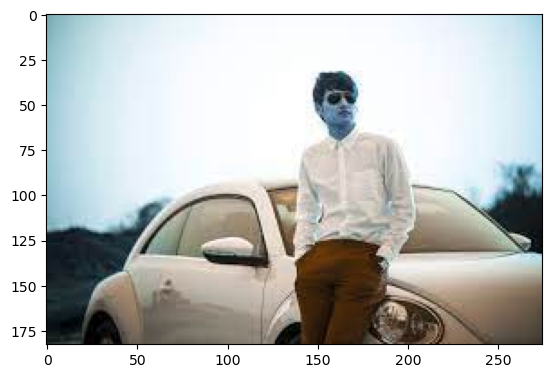

In [37]:
plt.imshow(img) #bgr

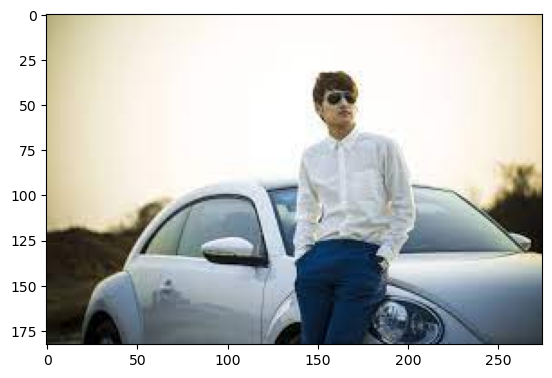

In [38]:
# Display an image using matplotlib, converting the color format from BGR to RGB
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


In [39]:
# Use the object detection model to detect objects in the image
ClassIndex, confidence, bbox = model.detect(img, confThreshold=0.55)


In [40]:
print(ClassIndex)
print(confidence)
print(bbox)

[3 1]
[0.65857035 0.6409153 ]
[[ 15  93 259  90]
 [133  31  74 152]]


In [41]:
# Set the font scale for text
font_scale = 2

# Specify the font for the text
font = cv2.FONT_HERSHEY_PLAIN

# Iterate over each detected object
for ClassInd, conf, boxes in zip(ClassIndex.flatten(), confidence.flatten(), bbox):
    # Draw a rectangle around the detected object
    cv2.rectangle(img, boxes, (255, 0, 0), 2)

    # Put text label on the image with class label and confidence
    cv2.putText(img, classLabels[ClassInd - 1], (boxes[0] + 10, boxes[1] + 40),
                font, fontScale=font_scale, color=(0, 255, 0), thickness=3)


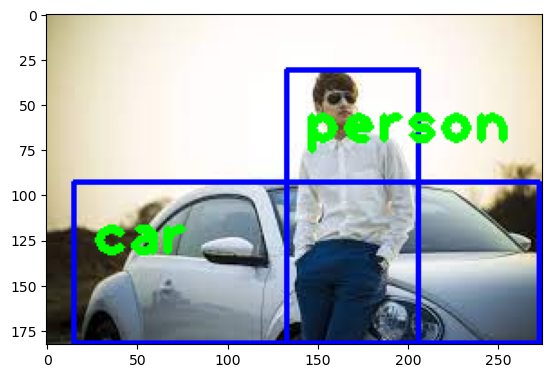

In [42]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))


Object Detection for video

In [43]:
import datetime

input_size = (400, 400)  
model.setInputSize(input_size)

# Initialize class count dictionary
class_count = {}

cap = cv2.VideoCapture('Demo_video.mp4')

font_scale = 3
font = cv2.FONT_HERSHEY_PLAIN

font_color = (0, 0, 0)  # Black color
font_thickness = 2

start_time = datetime.datetime.now()
while True:
    ret, frame = cap.read()

    # Check if the frame is empty (end of video stream)
    if not ret:
        break

    # Resize the frame to match the model's input size
    resized_frame = cv2.resize(frame, input_size)

    # Detect objects in the resized frame
    ClassIndex, confidence, bbox = model.detect(resized_frame, confThreshold=0.60)

    # Reset class count for the current frame
    frame_class_count = {}

    if len(ClassIndex) != 0:
        for ClassInd, conf, boxes in zip(ClassIndex.flatten(), confidence.flatten(), bbox):
            if ClassInd <= 80:
                # Scale the bounding boxes back to the original frame size
                scaled_boxes = [int(boxes[0] * (frame.shape[1] / input_size[0])),
                                int(boxes[1] * (frame.shape[0] / input_size[1])),
                                int(boxes[2] * (frame.shape[1] / input_size[0])),
                                int(boxes[3] * (frame.shape[0] / input_size[1]))]

                # Get the class label
                class_label = classLabels[ClassInd - 1]

                # Update class count for the current frame
                frame_class_count[class_label] = frame_class_count.get(class_label, 0) + 1

                # Draw rectangle and display class label
                cv2.rectangle(frame, scaled_boxes, (255, 0, 0), 2)
                cv2.putText(frame, f'{class_label}: {frame_class_count[class_label]}',
                            (scaled_boxes[0] + 10, scaled_boxes[1] + 40),
                            font, fontScale=font_scale, color=font_color, thickness=font_thickness)

                # Calculate timestamp for the detected object in the current frame
                current_time_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
                timestamp_video_duration = str(datetime.timedelta(milliseconds=current_time_msec))
                cv2.putText(frame, f'Detected at {timestamp_video_duration}',
                            (int(scaled_boxes[0]), int(scaled_boxes[1]) - 20), font, fontScale=1,
                            color=font_color, thickness=font_thickness, lineType=cv2.LINE_AA)

        # Display class count for the current frame
        # Draw rectangle for text background
        cv2.rectangle(frame, (0, 0), (frame.shape[1], 50), (255, 255, 255), -1)
        count_text = ', '.join(f'{label}: {count}' for label, count in frame_class_count.items())
        cv2.putText(frame, f'Class Count: {count_text}', (10, 30), font, fontScale=1.75, color=font_color,
                    thickness=font_thickness, lineType=cv2.LINE_AA)

        # Display current video duration (overall)
        elapsed_time = datetime.timedelta(milliseconds=current_time_msec)
        cv2.putText(frame, f'Total Video Duration: {str(elapsed_time)[:-7]}', (10, 50), font, fontScale=1.75,
                    color=font_color, thickness=font_thickness, lineType=cv2.LINE_AA)

    # Display the frame with object detection results
    cv2.imshow('Object detection Tutorial', frame)

    # Video controls
    key = cv2.waitKey(1)
    if key == 27:  # Press 'Esc' to exit
        break
    elif key == ord('p'):  # Press 'p' to pause/play
        cv2.waitKey(-1)
    elif key == ord('f'):  # Press 'f' to fast forward by 5 seconds
        current_time_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
        cap.set(cv2.CAP_PROP_POS_MSEC, current_time_msec + 5000)
    elif key == ord('b'):  # Press 'b' to go backward by 5 seconds
        current_time_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
        cap.set(cv2.CAP_PROP_POS_MSEC, max(0, current_time_msec - 5000))

# Release video capture and close all windows
cap.release()
cv2.destroyAllWindows()


In [44]:
import datetime

input_size = (400, 400)  
model.setInputSize(input_size)

# Initialize class count dictionary
class_count = {}

cap = cv2.VideoCapture('Why Data Matters.mp4')

font_scale = 3
font = cv2.FONT_HERSHEY_PLAIN

font_color = (0, 0, 0)  # Black color
font_thickness = 2

start_time = datetime.datetime.now()
while True:
    ret, frame = cap.read()

    # Check if the frame is empty (end of video stream)
    if not ret:
        break

    # Resize the frame to match the model's input size
    resized_frame = cv2.resize(frame, input_size)

    # Detect objects in the resized frame
    ClassIndex, confidence, bbox = model.detect(resized_frame, confThreshold=0.60)

    # Reset class count for the current frame
    frame_class_count = {}

    if len(ClassIndex) != 0:
        for ClassInd, conf, boxes in zip(ClassIndex.flatten(), confidence.flatten(), bbox):
            if ClassInd <= 80:
                # Scale the bounding boxes back to the original frame size
                scaled_boxes = [int(boxes[0] * (frame.shape[1] / input_size[0])),
                                int(boxes[1] * (frame.shape[0] / input_size[1])),
                                int(boxes[2] * (frame.shape[1] / input_size[0])),
                                int(boxes[3] * (frame.shape[0] / input_size[1]))]

                # Get the class label
                class_label = classLabels[ClassInd - 1]

                # Update class count for the current frame
                frame_class_count[class_label] = frame_class_count.get(class_label, 0) + 1

                # Draw rectangle and display class label
                cv2.rectangle(frame, scaled_boxes, (255, 0, 0), 2)
                cv2.putText(frame, f'{class_label}: {frame_class_count[class_label]}',
                            (scaled_boxes[0] + 10, scaled_boxes[1] + 40),
                            font, fontScale=font_scale, color=font_color, thickness=font_thickness)

                # Calculate timestamp for the detected object in the current frame
                current_time_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
                timestamp_video_duration = str(datetime.timedelta(milliseconds=current_time_msec))
                cv2.putText(frame, f'Detected at {timestamp_video_duration}',
                            (int(scaled_boxes[0]), int(scaled_boxes[1]) - 20), font, fontScale=1,
                            color=font_color, thickness=font_thickness, lineType=cv2.LINE_AA)

        # Display class count for the current frame
        # Draw rectangle for text background
        cv2.rectangle(frame, (0, 0), (frame.shape[1], 50), (255, 255, 255), -1)
        count_text = ', '.join(f'{label}: {count}' for label, count in frame_class_count.items())
        cv2.putText(frame, f'Class Count: {count_text}', (10, 30), font, fontScale=1.75, color=font_color,
                    thickness=font_thickness, lineType=cv2.LINE_AA)

        # Display current video duration (overall)
        elapsed_time = datetime.timedelta(milliseconds=current_time_msec)
        cv2.putText(frame, f'Total Video Duration: {str(elapsed_time)[:-7]}', (10, 50), font, fontScale=1.75,
                    color=font_color, thickness=font_thickness, lineType=cv2.LINE_AA)

    # Display the frame with object detection results
    cv2.imshow('Object detection Tutorial', frame)

    # Video controls
    key = cv2.waitKey(1)
    if key == 27:  # Press 'Esc' to exit
        break
    elif key == ord('p'):  # Press 'p' to pause/play
        cv2.waitKey(-1)
    elif key == ord('f'):  # Press 'f' to fast forward by 5 seconds
        current_time_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
        cap.set(cv2.CAP_PROP_POS_MSEC, current_time_msec + 5000)
    elif key == ord('b'):  # Press 'b' to go backward by 5 seconds
        current_time_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
        cap.set(cv2.CAP_PROP_POS_MSEC, max(0, current_time_msec - 5000))

# Release video capture and close all windows
cap.release()
cv2.destroyAllWindows()


In [45]:
# with csv file
import cv2
import matplotlib.pyplot as plt
import datetime

# Specify the path to the configuration file for the SSD model
config_file = 'ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt'
# Specify the filename for the frozen inference graph of the SSD model
frozen_model = 'frozen_inference_graph.pb'

# Create a DNN-based detection model using OpenCV
model = cv2.dnn_DetectionModel(frozen_model, config_file)

# Create an empty list to store class labels
classLabels = []
# Specify the filename containing class labels
file_name = 'labels.txt'

# Open the file and read class labels, removing trailing newline characters
with open(file_name, 'rt') as fpt:
    classLabels = fpt.read().rstrip('\n').split('\n')

model.setInputSize(320, 320)
model.setInputScale(1.0 / 127.5)
model.setInputMean((127.5, 127.5, 127.5))
model.setInputSwapRB(True)

input_size = (400, 400)
model.setInputSize(input_size)

# Initialize class count dictionary
class_count = {}

cap = cv2.VideoCapture('Demo_video.mp4')

font_scale = 3
font = cv2.FONT_HERSHEY_PLAIN

font_color = (0, 0, 0)  # Black color
font_thickness = 2

# Open a CSV file for writing
csv_filename = 'detections.csv'
csv_file = open(csv_filename, 'w')
csv_file.write("Frame,Class,Count,X,Y,Width,Height,Time\n")

start_time = datetime.datetime.now()
while True:
    ret, frame = cap.read()

    # Check if the frame is empty (end of video stream)
    if not ret:
        break

    # Resize the frame to match the model's input size
    resized_frame = cv2.resize(frame, input_size)

    # Detect objects in the resized frame
    ClassIndex, confidence, bbox = model.detect(resized_frame, confThreshold=0.60)

    # Reset class count for the current frame
    frame_class_count = {}

    if len(ClassIndex) != 0:
        for ClassInd, conf, boxes in zip(ClassIndex.flatten(), confidence.flatten(), bbox):
            if ClassInd <= 80:
                # Scale the bounding boxes back to the original frame size
                scaled_boxes = [int(boxes[0] * (frame.shape[1] / input_size[0])),
                                int(boxes[1] * (frame.shape[0] / input_size[1])),
                                int(boxes[2] * (frame.shape[1] / input_size[0])),
                                int(boxes[3] * (frame.shape[0] / input_size[1]))]

                # Get the class label
                class_label = classLabels[ClassInd - 1]

                # Update class count for the current frame
                frame_class_count[class_label] = frame_class_count.get(class_label, 0) + 1

                # Draw rectangle and display class label
                cv2.rectangle(frame, scaled_boxes, (255, 0, 0), 2)
                cv2.putText(frame, f'{class_label}: {frame_class_count[class_label]}',
                            (scaled_boxes[0] + 10, scaled_boxes[1] + 40),
                            font, fontScale=font_scale, color=font_color, thickness=font_thickness)

                # Calculate timestamp for the detected object in the current frame
                current_time_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
                timestamp_video_duration = str(datetime.timedelta(milliseconds=current_time_msec))
                cv2.putText(frame, f'Detected at {timestamp_video_duration}',
                            (int(scaled_boxes[0]), int(scaled_boxes[1]) - 20), font, fontScale=1,
                            color=font_color, thickness=font_thickness, lineType=cv2.LINE_AA)

                # Write detection information to CSV file
                csv_file.write(f"{cap.get(cv2.CAP_PROP_POS_FRAMES)},{class_label},{frame_class_count[class_label]},"
                               f"{scaled_boxes[0]},{scaled_boxes[1]},{scaled_boxes[2] - scaled_boxes[0]},"
                               f"{scaled_boxes[3] - scaled_boxes[1]},{timestamp_video_duration}\n")

        # Display class count for the current frame
        # Draw rectangle for text background
        cv2.rectangle(frame, (0, 0), (frame.shape[1], 50), (255, 255, 255), -1)
        count_text = ', '.join(f'{label}: {count}' for label, count in frame_class_count.items())
        cv2.putText(frame, f'Class Count: {count_text}', (10, 30), font, fontScale=1.75, color=font_color,
                    thickness=font_thickness, lineType=cv2.LINE_AA)

        # Display current video duration (overall)
        elapsed_time = datetime.timedelta(milliseconds=current_time_msec)
        cv2.putText(frame, f'Total Video Duration: {str(elapsed_time)[:-7]}', (10, 50), font, fontScale=1.75,
                    color=font_color, thickness=font_thickness, lineType=cv2.LINE_AA)

    # Display the frame with object detection results
    cv2.imshow('Object detection Tutorial', frame)

    # Video controls
    key = cv2.waitKey(1)
    if key == 27:  # Press 'Esc' to exit
        break
    elif key == ord('p'):  # Press 'p' to pause/play
        cv2.waitKey(-1)
    elif key == ord('f'):  # Press 'f' to fast forward by 5 seconds
        current_time_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
        cap.set(cv2.CAP_PROP_POS_MSEC, current_time_msec + 5000)
    elif key == ord('b'):  # Press 'b' to go backward by 5 seconds
        current_time_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
        cap.set(cv2.CAP_PROP_POS_MSEC, max(0, current_time_msec - 5000))

# Release video capture, close CSV file, and close all windows
cap.release()
csv_file.close()
cv2.destroyAllWindows()


In [ ]:
# Why Data Matters with csv
import cv2
import matplotlib.pyplot as plt
import datetime

# Specify the path to the configuration file for the SSD model
config_file = 'ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt'
# Specify the filename for the frozen inference graph of the SSD model
frozen_model = 'frozen_inference_graph.pb'

# Create a DNN-based detection model using OpenCV
model = cv2.dnn_DetectionModel(frozen_model, config_file)

# Create an empty list to store class labels
classLabels = []
# Specify the filename containing class labels
file_name = 'labels.txt'

# Open the file and read class labels, removing trailing newline characters
with open(file_name, 'rt') as fpt:
    classLabels = fpt.read().rstrip('\n').split('\n')

model.setInputSize(320, 320)
model.setInputScale(1.0 / 127.5)
model.setInputMean((127.5, 127.5, 127.5))
model.setInputSwapRB(True)

input_size = (400, 400)
model.setInputSize(input_size)

# Initialize class count dictionary
class_count = {}

cap = cv2.VideoCapture(0)

font_scale = 3
font = cv2.FONT_HERSHEY_PLAIN

font_color = (0, 0, 0)  # Black color
font_thickness = 2

# Open a CSV file for writing
csv_filename = 'detectionss.csv'
csv_file = open(csv_filename, 'w')
csv_file.write("Frame,Class,Count,X,Y,Width,Height,Time\n")

start_time = datetime.datetime.now()
while True:
    ret, frame = cap.read()

    # Check if the frame is empty (end of video stream)
    if not ret:
        break

    # Resize the frame to match the model's input size
    resized_frame = cv2.resize(frame, input_size)

    # Detect objects in the resized frame
    ClassIndex, confidence, bbox = model.detect(resized_frame, confThreshold=0.60)

    # Reset class count for the current frame
    frame_class_count = {}

    if len(ClassIndex) != 0:
        for ClassInd, conf, boxes in zip(ClassIndex.flatten(), confidence.flatten(), bbox):
            if ClassInd <= 80:
                # Scale the bounding boxes back to the original frame size
                scaled_boxes = [int(boxes[0] * (frame.shape[1] / input_size[0])),
                                int(boxes[1] * (frame.shape[0] / input_size[1])),
                                int(boxes[2] * (frame.shape[1] / input_size[0])),
                                int(boxes[3] * (frame.shape[0] / input_size[1]))]

                # Get the class label
                class_label = classLabels[ClassInd - 1]

                # Update class count for the current frame
                frame_class_count[class_label] = frame_class_count.get(class_label, 0) + 1

                # Draw rectangle and display class label
                cv2.rectangle(frame, scaled_boxes, (255, 0, 0), 2)
                cv2.putText(frame, f'{class_label}: {frame_class_count[class_label]}',
                            (scaled_boxes[0] + 10, scaled_boxes[1] + 40),
                            font, fontScale=font_scale, color=font_color, thickness=font_thickness)

                # Calculate timestamp for the detected object in the current frame
                current_time_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
                timestamp_video_duration = str(datetime.timedelta(milliseconds=current_time_msec))
                cv2.putText(frame, f'Detected at {timestamp_video_duration}',
                            (int(scaled_boxes[0]), int(scaled_boxes[1]) - 20), font, fontScale=1,
                            color=font_color, thickness=font_thickness, lineType=cv2.LINE_AA)

                # Write detection information to CSV file
                csv_file.write(f"{cap.get(cv2.CAP_PROP_POS_FRAMES)},{class_label},{frame_class_count[class_label]},"
                               f"{scaled_boxes[0]},{scaled_boxes[1]},{scaled_boxes[2] - scaled_boxes[0]},"
                               f"{scaled_boxes[3] - scaled_boxes[1]},{timestamp_video_duration}\n")

        # Display class count for the current frame
        # Draw rectangle for text background
        cv2.rectangle(frame, (0, 0), (frame.shape[1], 50), (255, 255, 255), -1)
        count_text = ', '.join(f'{label}: {count}' for label, count in frame_class_count.items())
        cv2.putText(frame, f'Class Count: {count_text}', (10, 30), font, fontScale=1.75, color=font_color,
                    thickness=font_thickness, lineType=cv2.LINE_AA)

        # Display current video duration (overall)
        elapsed_time = datetime.timedelta(milliseconds=current_time_msec)
        cv2.putText(frame, f'Total Video Duration: {str(elapsed_time)[:-7]}', (10, 50), font, fontScale=1.75,
                    color=font_color, thickness=font_thickness, lineType=cv2.LINE_AA)

    # Display the frame with object detection results
    cv2.imshow('Object detection Tutorial', frame)

    # Video controls
    key = cv2.waitKey(1)
    if key == 27:  # Press 'Esc' to exit
        break
    elif key == ord('p'):  # Press 'p' to pause/play
        cv2.waitKey(-1)
    elif key == ord('f'):  # Press 'f' to fast forward by 5 seconds
        current_time_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
        cap.set(cv2.CAP_PROP_POS_MSEC, current_time_msec + 5000)
    elif key == ord('b'):  # Press 'b' to go backward by 5 seconds
        current_time_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
        cap.set(cv2.CAP_PROP_POS_MSEC, max(0, current_time_msec - 5000))

# Release video capture, close CSV file, and close all windows
cap.release()
csv_file.close()
cv2.destroyAllWindows()
